# Face recognition
Task is to recognize a faces

### Dataset
**Aligned Face Dataset from Pinterest**

This dataset contains 10.770 images for 100 people. All images are taken from 'Pinterest' and      aligned using dlib library.

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import tensorflow
tensorflow.__version__

'2.1.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Change current working directory to project folder 

In [0]:
import os
os.chdir('/content//drive/My Drive/GL/Colab Notebooks')


Extract the zip file 
Extract Aligned Face Dataset from Pinterest.zip

In [0]:
import zipfile
from zipfile import ZipFile

if not os.path.exists('MODEL'):
  os.makedirs('MODEL')
  # UNZIP ZIP
  print ("Uncompressing zip file")
  zip_ref = zipfile.ZipFile('Pinterest.zip', 'r')
  zip_ref.extractall('MODEL/')
  zip_ref.close()

Function to load images
Define a function to load the images from the extracted folder and map each image with person id

In [0]:
import numpy as np
import os

os.chdir('/content//drive/My Drive/GL/Colab Notebooks/MODEL')

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

Define function to load image
Define a function to load image from the metadata

In [0]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]
   

Load a sample image 
Load one image using the function "load_image"

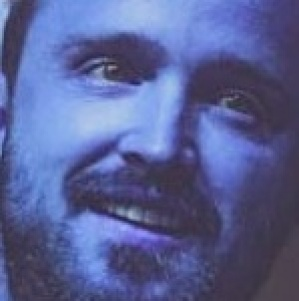

In [8]:
from google.colab.patches import cv2_imshow

img = load_image('PINS/pins_Aaron Paul/Aaron Paul0_262.jpg')
cv2_imshow(img)


### VGG Face model
- Here we are giving you the predefined model for VGG face

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model


Load the model defined above


In [10]:
from keras.models import load_model 
vgg_model = vgg_face()
vgg_model.summary()


Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

Load the given weight file named "vgg_face_weights.h5"

In [0]:
vgg_model.load_weights('/content/drive/My Drive/GL/Colab Notebooks/vgg_face_weights.h5')



### Get vgg_face_descriptor

In [0]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=vgg_model.layers[0].input, outputs=vgg_model.layers[-2].output)

### Generate embeddings for each image in the dataset
Loading the first image in the metadata and get its embedding vector from the pre-trained model. 

In [13]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)


img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


Generate embeddings for all images 
Write code to iterate through metadata and create embeddings for each image using vgg_face_descriptor.predict() and store in a list with name embeddings

If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [14]:
import tensorflow.keras.backend as K
import numpy as np
embeddings = np.zeros((metadata.shape[0]), dtype=object)
embedding_vector=np.zeros((metadata.shape[0]), dtype=object)



for i, m in enumerate(metadata):

  try:
    img_path = metadata[i].image_path()
    img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    #img = img.transpose((1,0,2))
    print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
    if(i < 500):
      embedding_vector[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    else:
      break
  except:
    embedding_vector[i] = np.zeros(2622,)
  print(i)
print(embedding_vector.shape)
 



(224, 224, 3)
0
(224, 224, 3)
1
(224, 224, 3)
2
(224, 224, 3)
3
(224, 224, 3)
4
(224, 224, 3)
5
(224, 224, 3)
6
(224, 224, 3)
7
(224, 224, 3)
8
(224, 224, 3)
9
(224, 224, 3)
10
(224, 224, 3)
11
(224, 224, 3)
12
(224, 224, 3)
13
(224, 224, 3)
14
(224, 224, 3)
15
(224, 224, 3)
16
(224, 224, 3)
17
(224, 224, 3)
18
(224, 224, 3)
19
(224, 224, 3)
20
(224, 224, 3)
21
(224, 224, 3)
22
(224, 224, 3)
23
(224, 224, 3)
24
(224, 224, 3)
25
(224, 224, 3)
26
(224, 224, 3)
27
(224, 224, 3)
28
(224, 224, 3)
29
(224, 224, 3)
30
(224, 224, 3)
31
(224, 224, 3)
32
(224, 224, 3)
33
(224, 224, 3)
34
(224, 224, 3)
35
(224, 224, 3)
36
(224, 224, 3)
37
(224, 224, 3)
38
(224, 224, 3)
39
(224, 224, 3)
40
(224, 224, 3)
41
(224, 224, 3)
42
(224, 224, 3)
43
(224, 224, 3)
44
(224, 224, 3)
45
(224, 224, 3)
46
(224, 224, 3)
47
(224, 224, 3)
48
(224, 224, 3)
49
(224, 224, 3)
50
(224, 224, 3)
51
(224, 224, 3)
52
(224, 224, 3)
53
(224, 224, 3)
54
(224, 224, 3)
55
(224, 224, 3)
56
(224, 224, 3)
57
(224, 224, 3)
58
(224, 2

Function to calculate distance between given 2 pairs of images.
Consider distance metric as "Squared L2 distance"
Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [0]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

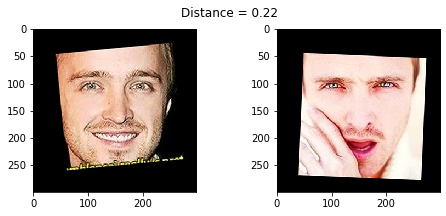

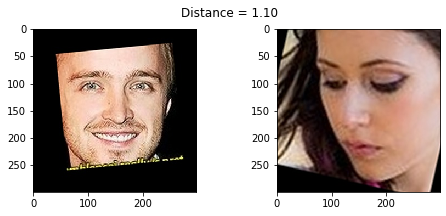

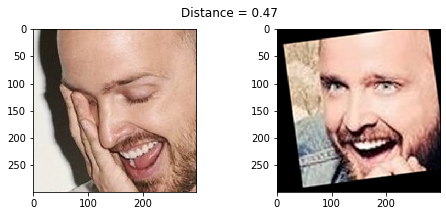

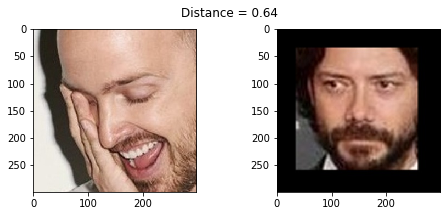

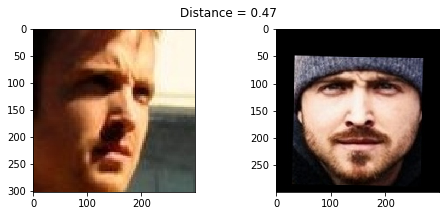

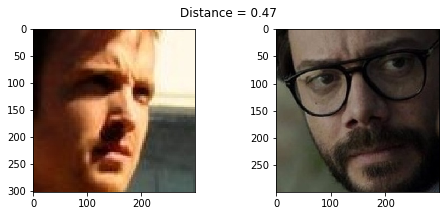

In [16]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedding_vector[idx1], embedding_vector[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)
show_pair(30, 31)
show_pair(30, 100)
show_pair(70, 72)
show_pair(70, 115)

### Create train and test sets
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

import numpy as np
from sklearn.metrics import  accuracy_score
from sklearn.decomposition import PCA


targets = np.array([m.name for m in metadata])
print(targets)
encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

embedding_vector=np.zeros((metadata.shape[0]), dtype=object)
embedding_vector=embedding_vector.reshape(embedding_vector.shape[0],-1)

X_train = embedding_vector[train_idx]
X_test = embedding_vector[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]



#svc = LinearSVC()
svm = SVC(kernel='linear', probability=False, random_state=42)

svm.fit(X_train, y_train)


# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)










['pins_Aaron Paul' 'pins_Aaron Paul' 'pins_Aaron Paul' ... 'pins_zendaya'
 'pins_zendaya' 'pins_zendaya']
Model accuracy is:  0.016898792943361187


0.016898792943361187

In [34]:
from sklearn.preprocessing import StandardScaler

# create scaler
scaler = StandardScaler()
# fit scaler on data
scaler.fit(X_train)
# apply transform
standardized = scaler.transform(X_train)
# inverse transform
inverse = scaler.inverse_transform(standardized)

pca = PCA(n_components = 1,svd_solver='full')

tstModel_train = pca.fit_transform(inverse)

# create scaler
X_test_scaler = StandardScaler()
# fit scaler on data
X_test_scaler.fit(X_test)
# apply transform
X_standardized = X_test_scaler.transform(X_test)
# inverse transform
X_test_inverse = X_test_scaler.inverse_transform(X_standardized)

pca = PCA(n_components = 1,svd_solver='full')

tstModel_test = pca.fit_transform(X_test_inverse)

svc = LinearSVC()
svc.fit(tstModel_train, y_train)


acc_svc = accuracy_score(y_test, svc.predict(tstModel_test))
acc_svc


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:456: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


0.016898792943361187

Test results 
Take 10th image from test set and plot the image
Report to which person(folder name in dataset) the image belongs to

In [0]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())

example_prediction = svc.predict([embedding_vector[test_idx][example_idx]])

example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

In [0]:
import os

os.chdir('/content//drive/My Drive/GL/Colab Notebooks/')

img_train_test_split("MODEL/PINS", 0.7)

In [0]:

import os
import random
from shutil import copyfile

def img_train_test_split(img_source_dir, train_size):
    """
    Randomly splits images over a train and validation folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')

    print(os.listdir(img_source_dir)) 
        
    # Set up empty folder structure if not exists
    if not os.path.exists('data'):
        os.makedirs('data')
    else:
        if not os.path.exists('data/train'):
            os.makedirs('data/train')
        if not os.path.exists('data/validation'):
            os.makedirs('data/validation')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('data/train', subdir)
        validation_subdir = os.path.join('data/validation', subdir)

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)

        train_counter = 0
        validation_counter = 0

        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                    train_counter += 1
                else:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                    validation_counter += 1
                    
        print('Copied ' + str(train_counter) + ' images to data/train/' + subdir)
        print('Copied ' + str(validation_counter) + ' images to data/validation/' + subdir)
